In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#import renet

import torchvision
import torchvision.transforms as transforms
from torchview import draw_graph

import os
from torchsummary import summary
import torch.utils.data as data
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes) # ochange

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [1,1,1,1])

In [3]:
model = ResNet18().to(device)
summary(model, (3, 32 ,32))


# model_graph = draw_graph(model, input_size=(1, 3, 32 , 32), expand_nested=True, save_graph=True)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

In [4]:
def train_and_evaluate_model(model, train_loader, test_loader, num_epochs, optName, learningRate):
    criterion = nn.CrossEntropyLoss()
    if optName == "SGD": 
        optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    else:
         optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    train_loss = []
    test_loss = []
    accuracy = []
    
    for epoch in range(num_epochs):
        # Training
        total_train = 0
        epoch_train_loss = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Testing
        correct_test = 0
        total_test = 0
        epoch_test_loss = 0
        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate test accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                epoch_test_loss += loss.item()
                
        # Print train and test loss and accuracy for the current epoch
        epoch_train_loss /= len(train_loader)
        epoch_test_loss /= len(test_loader)
        test_accuracy = 100 * correct_test / total_test
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f},\
        Test Loss: {epoch_test_loss}, Test acc: {test_accuracy}")
        
        train_loss.append(epoch_train_loss)
        test_loss.append(epoch_test_loss)
        accuracy.append(test_accuracy)
        
    return train_loss, test_loss, accuracy
#         wandb.log({"Epoch": epoch, "Train Loss": epoch_train_loss, "Test Loss": epoch_test_loss, "Test Accuracy": test_accuracy})

In [5]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
    n_holes (int): Number of patches to cut out of each image.
    length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
      self.n_holes = n_holes
      self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)
    
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
    
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.
    

        mask = torch.from_numpy(mask)
          
        mask = mask.expand_as(img)
              
        img = img * mask

    
      
        return img

In [6]:
def load_CIFAR10(batch_size, train_ratio, imageCut):

    ROOT = '/scratch/hx2214/data'
    trainset = torchvision.datasets.CIFAR10(
      root = ROOT,
      train = True, 
      download = True
    )

    # Compute means and standard deviations
    means = trainset.data.mean(axis=(0,1,2)) / 255
    stds = trainset.data.std(axis=(0,1,2)) / 255
    #print(means, stds)

    # Preprocess setting
    
    if(imageCut):
        transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=means, std=stds),
          Cutout(n_holes=1, length=16)
        ])
    else:
        transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=means, std=stds),
        ])
        
    transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=means, std=stds)
    ])

    # Load the dataset
    trainset = torchvision.datasets.CIFAR10(
      root = ROOT, 
      train = True, 
      download = True, 
      transform = transform_train
    )
    testset = torchvision.datasets.CIFAR10(
      root = ROOT, 
      train = False, 
      download = True, 
      transform = transform_test
    )

    train_iterator = data.DataLoader(trainset, batch_size)
    test_iterator = data.DataLoader(testset, batch_size)

    return train_iterator, test_iterator

    """
    # Split trainset for validset
    n_train = int(len(trainset) * train_ratio)
    n_valid = len(trainset) - n_train
    train_dataset, valid_dataset = data.random_split(trainset, [n_train, n_valid])

    # Build dataloader
    train_iterator = data.DataLoader(train_dataset, batch_size)
    valid_iterator = data.DataLoader(valid_dataset, batch_size)
    test_iterator = data.DataLoader(testset, batch_size)

    return train_iterator, valid_iterator, test_iterator
    """

In [7]:
def plots(train_loss, test_loss, acc, epochs):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    
    ax1.plot(epochs, train_loss, label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    
    ax2.plot(epochs, test_loss, label='Testing Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Testing Loss')
    ax2.set_title('Testing Loss')
    ax2.legend()
    
    ax3.plot(epochs, acc, label='Accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
sweep_config = {
    "name": "dl_miniProject",
    'method': 'random'
    }

parameters_dict = {
    'batchSize':{
        'values':[32]
    },
    'imageCut':{
        'values':[True]
    },
    'optimizer': {
        'values': ['Adam']
        },
    "learning_rate": {
            "values": [0.001]
        }
    }
  
sweep_config['parameters'] = parameters_dict

In [11]:
def tuning(config=None):
    for size in parameters_dict['batchSize']['values']:
        for imageCut in parameters_dict['imageCut']['values']:
            model = ResNet18().to(device)
            train_loader, test_loader = load_CIFAR10(size, 1, imageCut)
            train_loss, test_loss, acc = train_and_evaluate_model(model, train_loader, test_loader, 35, "Adam", 0.001)
            print(len(train_loss))
            plots(train_loss, test_loss, acc, np.arange(35))
    

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/35], Train Loss: 1.5525,        Test Loss: 1.2733187481237296, Test acc: 54.86
Epoch [2/35], Train Loss: 1.1748,        Test Loss: 1.0016712287363534, Test acc: 65.35
Epoch [3/35], Train Loss: 1.0086,        Test Loss: 0.8715974844682711, Test acc: 70.4
Epoch [4/35], Train Loss: 0.8969,        Test Loss: 0.7395820030674767, Test acc: 74.79
Epoch [5/35], Train Loss: 0.8004,        Test Loss: 0.6237341016530991, Test acc: 78.69
Epoch [6/35], Train Loss: 0.7274,        Test Loss: 0.6096398616179871, Test acc: 79.08
Epoch [7/35], Train Loss: 0.6683,        Test Loss: 0.5572848571851231, Test acc: 80.86
Epoch [8/35], Train Loss: 0.6259,        Test Loss: 0.5001716435241242, Test acc: 82.9
Epoch [9/35], Train Loss: 0.5807,        Test Loss: 0.4723034252802404, Test acc: 84.1
Epoch [10/35], Train Loss: 0.5462,        Test Loss: 0.4746902173224349, Test acc: 84.52
Epoch [1

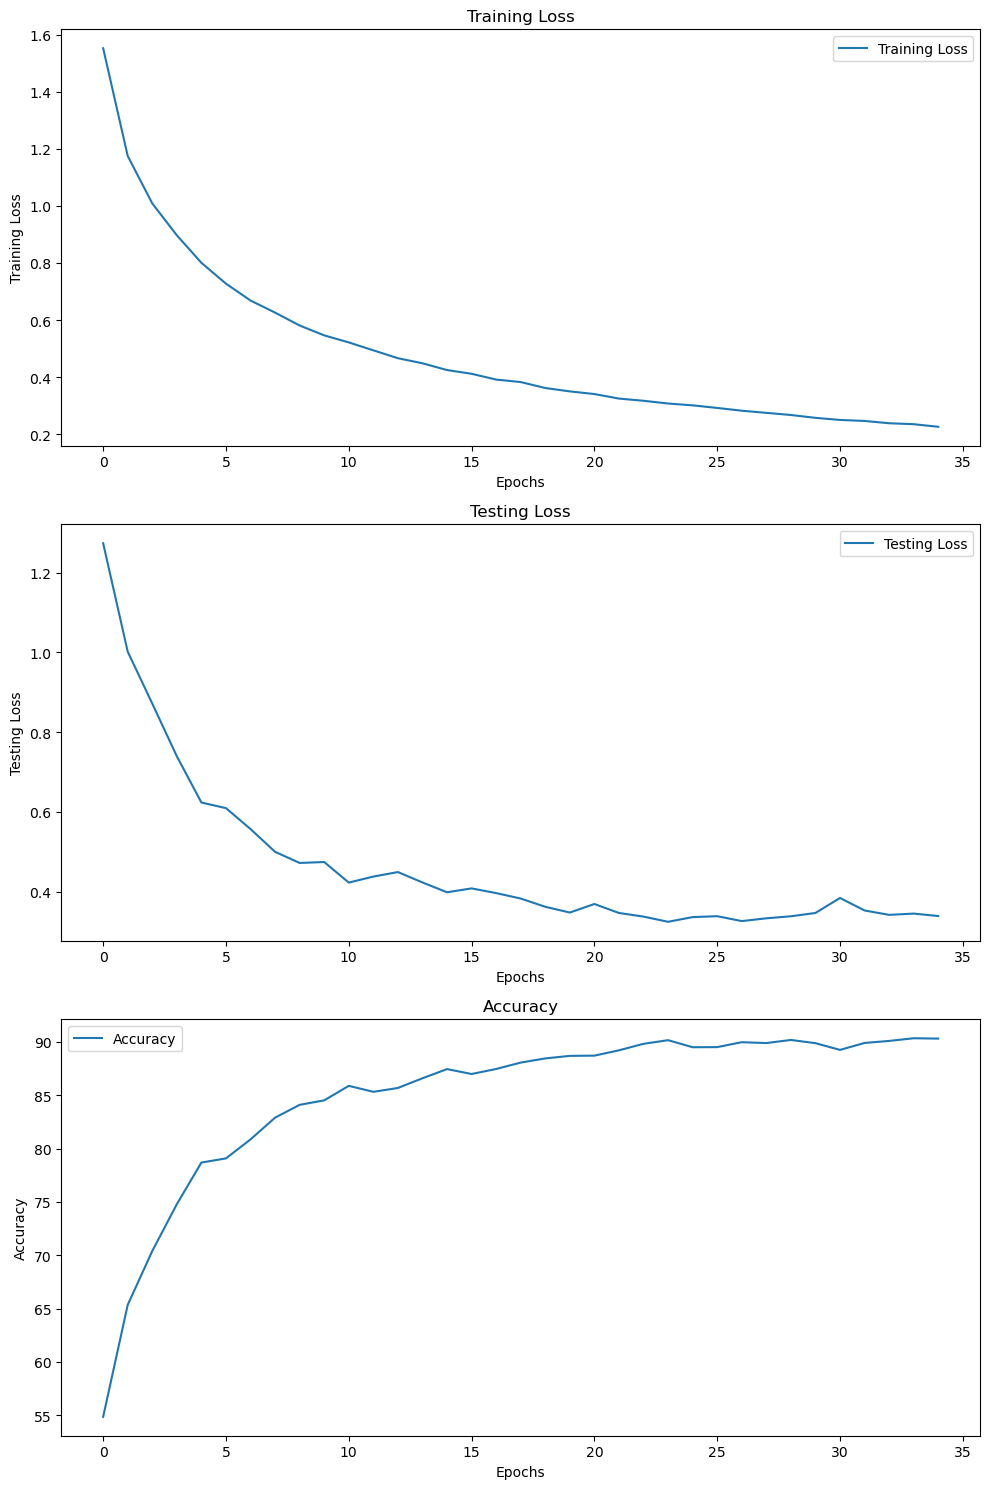

In [12]:
tuning()